# Assignment 5 : Logistic Regression


- Logistic regression is a statistical method for analyzing a dataset in which there are one or more                       independent variables that determine an outcome. The outcome is measured with a binary variable.
- The relationship between X and Y is non_linear then we use Logistic regression.
- It is used to describe data and to explain the relationship between one dependent binary variable and one or more           nominal, ordinal, interval or ratio-level independent variables.

          log(p(x) / (p(1-x)) = w0 + w1*X1
          
          so, p(x) = 1 / (1 + exp(-(w0 + w1*x1)))
          
- Dependent variable must be bernouli distribution.
- It does not assume linear relationship between dependent and independent variable.
- It is robust as it does not require independent variables to follow normal distribution.

In [5]:
#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pickle 
def savetofile(obj,filename):
    pickle.dump(obj,open(filename,"wb"))
    
def openfromfile(filename):
    temp=pickle.load(open(filename,"rb"))
    return temp

In [6]:
#Loading the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

from sklearn.model_selection import RandomizedSearchCV
from scipy.sparse import find
from numpy import random
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim

In [7]:
#Loading the dataset
data_frame = openfromfile("New_Amazon_preprocess_data")

In [8]:
#Shape of data
print("Shape of data_frame:", data_frame.shape)

#First five rows of the data_frame
data_frame.head()

Shape of data_frame: (364171, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
515425,515426,141278509X,AB1A5EGHHVA9M,CHelmic,1,1,positive,1332547200,The best drink mix,This product by Archer Farms is the best drink...,product archer farm best drink mix ever mix fl...
24750,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,positive,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dog love saw pet store tag attach regard made ...
24749,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,negative,1192060800,made in china,My dogs loves this chicken but its a product f...,dog love chicken product china wont buy anymor...
308076,308077,2841233731,A3QD68O22M2XHQ,LABRNTH,0,0,positive,1345852800,Great recipe book for my babycook,This book is easy to read and the ingredients ...,book easi read ingredi avail store unlik recip...
150523,150524,6641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...


In [9]:
#Storing the data_frame based on the time attribute
data_frame.sort_values('Time', inplace=True)

#Reseting the data_frame
data_frame.reset_index(drop=False, inplace=True)

In [10]:
#In the Score attribute consisting of two categories changing positive to 1 and negative to 0
data_frame.Score = [1 if(score == 'positive') else 0 for score in data_frame.Score]

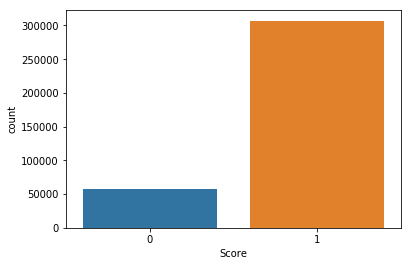

1    307061
0     57110
Name: Score, dtype: int64

In [11]:
#Count plot for score attribute 
sns.countplot(x=data_frame.Score, data=data_frame)
plt.show()
data_frame.Score.value_counts()

In [12]:
#Storing the cleanedtext attribute into X and Score attribute into the Y
X = data_frame.CleanedText

y = data_frame.Score

In [13]:
#Splitting the data into train as 70% and test as 30%
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [14]:
#shape of train and test data
print("Shape of the train data:", X_tr.shape)

print("Shape of the test data:", X_test.shape)

Shape of the train data: (254919,)
Shape of the test data: (109252,)


# BOW: 

 which means makes a vector for each review of length unique words from the whole dataset and makes frequency count of word.
 
- Bow or Bag of Words which means way of extracting features from text for use in modeling.
- A bag-of-words is a representation of text that describes the occurrence of words within a document. 
   
   It involves two things:
                1.vocabulary of known words.
                2.Measure of the presence of known words.
-  It is called a “bag” of words, because any information about the order or structure of words in the document is              discarded. The model is only concerned with whether known words occur in the document, not where in the document.

In [15]:

%%time

count_vec = CountVectorizer()
#Making the fit_transform for train data
bow_tr = count_vec.fit_transform(X_tr)

Wall time: 8.61 s


In [16]:
#Transform for test data
bow_test = count_vec.transform(X_test)

In [17]:
#Nomalizing the train and test data
bow_tr = preprocessing.normalize(bow_tr)
bow_test = preprocessing.normalize(bow_test)

In [18]:
#Shape of train and test data after the bag of words
print("shape of train data:", bow_tr.shape)
print("shape of test data:", bow_test.shape)

shape of train data: (254919, 78610)
shape of test data: (109252, 78610)


### 1. Hyperparameter tunning using grid seach and random search cross validation:

**  Grid Search Cross Validation:**

- working through multiple combinations of parameter tunes, cross validate each and determine                                  which one gives the best performance.      
    
- Note: In grid search, if you choosen n paramters then we will have to check 2^n combinations.

![title](grid search cross validation.png)

** Time based splitting:** 

- Provides train/test indices to split time series data samples that are observed at fixed time                                 intervals, in train/test sets.In each split, test indices must be higher than before, and thus shuffling in cross
  validator is inappropriate.

![title](time series split.png)

In [38]:
#Function for Grid Search Cross Validation
def grid_search(X_train, y_train):
    #Assigning the values for hyperperameter and regularization as l1 and l2
    parameters = {'C':[1000,100,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001],'penalty':['l1','l2']}

    #splitting the data based on the time series
    tbs = TimeSeriesSplit(n_splits=5)

    log_model = LogisticRegression()

    #Grid Search Cross Validation using logistic regression
    gsv = GridSearchCV(log_model, parameters, scoring='accuracy', n_jobs=3, cv=tbs, verbose=3)
    gsv.fit(X_train, y_train)

    #Best hyperparameter value
    print("optimal hyperparameter:", gsv.best_params_)
    print("Best Accuracy:", gsv.best_score_ * 100)
    
    return gsv.grid_scores_, gsv.best_estimator_

In [19]:

%%time

#Calling the function for Grid Search Cross Validation
grid_scores, best_estimator = grid_search(bow_tr, y_tr)

Fitting 5 folds for each of 22 candidates, totalling 110 fits


[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  4.9min
[Parallel(n_jobs=3)]: Done 110 out of 110 | elapsed:  7.2min finished


optimal hyperparameter: {'C': 10, 'penalty': 'l2'}
Best Accuracy: 91.9818293084781
Wall time: 7min 32s


In [20]:
grid_scores[:3]

[mean: 0.88436, std: 0.00966, params: {'C': 1000, 'penalty': 'l1'},
 mean: 0.90436, std: 0.00334, params: {'C': 1000, 'penalty': 'l2'},
 mean: 0.90075, std: 0.00446, params: {'C': 100, 'penalty': 'l1'}]

In [39]:
#Function for plot between hyperparameter C and cv_errors

def param_cv_error(hyperparameters, cv_errors):
    plt.plot(hyperparameters, cv_errors)
    plt.title("hyperparameters vs cv_errors")
    plt.xlabel("hyperparameters")
    plt.ylabel("cv_errors")
    plt.show()

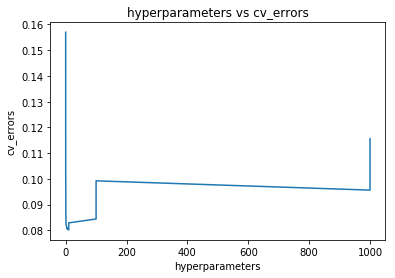

In [22]:

hy_params = [val[0]['C'] for val in grid_scores]

cv_errors = [1-val[1] for val in grid_scores]

#Calling the function for plot between C and cv_errors
param_cv_error(hy_params, cv_errors)

** Testing the model from best_estimator which can be return by the grid search cross validation.**

In [23]:
#Result showing the best classifier consisting of parameters
best_estimator

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [24]:
#Finding the predicted values for test labels using the test data
y_pred = best_estimator.predict(bow_test)

In [62]:
#Function for calculating the metrics
def test_metrics(y_test, y_pred):
    cm = pd.DataFrame(confusion_matrix(y_test,y_pred),range(2),range(2))
    sns.set(font_scale=1.5)
    sns.heatmap(cm,annot=True,annot_kws={"size": 20}, fmt='g', vmin=0, vmax=109252)

    print("Accuracy on test data:", round(accuracy_score(y_test, y_pred) * 100 , 2))
    print("Precision on test data:", round(precision_score(y_test, y_pred) * 100 , 2))
    print("Recall on test data:", round(recall_score(y_test, y_pred) * 100 , 2))
    print("F1_score on test data:", round(f1_score(y_test, y_pred) * 100,2))

    plt.show()

Accuracy on test data: 91.85
Precision on test data: 93.43
Recall on test data: 96.93
F1_score on test data: 95.15


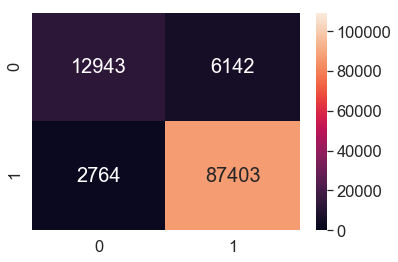

In [26]:
#Calling the function for test metrics
test_metrics(y_test, y_pred)

** Random Search cross validation:** 
- implements a randomized search over parameters, where each setting is sampled from a distribution over possible parameter values. 



- This has two main benefits over an exhaustive search:
    1. A budget can be chosen independent of the number of parameters and possible values
    2. Adding parameters that do not influence the performance does not decrease efficiency.
   



- Note: In random search, if you choosen n paramters then we will have to check n combinations.

![title](random search cross validation.png)

In [40]:
#Function for random Search Cross Validation

def random_search(X_train, y_train):
    #Assigning the values for hyperperameter and regularization as l1 and l2
    parameters = {'C': np.arange(1, 1000), 'penalty':['l1','l2']}

    #splitting the data based on the time series
    tbs = TimeSeriesSplit(n_splits=5)

    log_model = LogisticRegression()
    #Random search for hyperparameter tuning
    rsv = RandomizedSearchCV(log_model, parameters, scoring='accuracy', n_jobs=3, cv=tbs, verbose=3)

    rsv.fit(X_train, y_train)

    print("optimal hyperparameter:",rsv.best_params_)
    print("Best accuracy:",rsv.best_score_*100)
    return rsv.best_estimator_

In [28]:

%%time

#Calling the function for random search cross validation
best_estimator = random_search(bow_tr, y_tr)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  3.2min
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed: 11.3min finished


optimal hyperparameter: {'penalty': 'l2', 'C': 239}
Best accuracy: 91.22864002259567
Wall time: 12min 38s


** Testing the model from best_estimator which can be return by the random search cross validation.**

In [29]:
#Result showing the best classifier consisting of parameters
best_estimator

LogisticRegression(C=239, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [30]:
#Finding the predicted values for test labels using the test data
y_pred = best_estimator.predict(bow_test)

Accuracy on test data: 91.31
Precision on test data: 93.46
Recall on test data: 96.2
F1_score on test data: 94.81


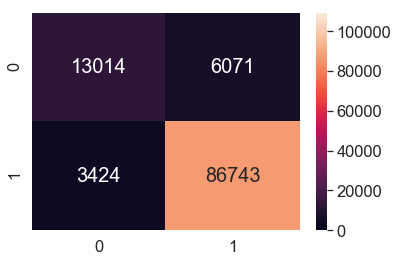

In [31]:
#Calling the function for test metrics
test_metrics(y_test, y_pred)

### 2. More Sparsity(Fewer elements of w* being non-zero) as C deceases or lambda increases using L1-regularization:

In [41]:
#Function for number of non-zero elements in an vector
def non_zero_ele(X_train, y_train, C_value):
    #Specifying the classifier with the hyperparameter and l1-regularization
    clf = LogisticRegression(penalty='l1', C=C_value)
    clf.fit(X_train, y_train)
    #optimal weight vector 
    opt_w = clf.coef_
    #number of non-zero elements in an optimal vector
    print("Number of non_zero elements in optimal vector for C={} and l1_reg is {}:". format(C, np.count_nonzero(opt_w)))

In [33]:
#To find number of non_zero elements with the C=10 and l1_reg
C=10
non_zero_ele(bow_tr, y_tr, C)

Number of non_zero elements in optimal vector for C=10 and l1_reg is 11080:


In [35]:
#To find number of non_zero elements with the C=1 and l1_reg
C=1
non_zero_ele(bow_tr, y_tr, C)

Number of non_zero elements in optimal vector for C=1 and l1_reg is 2229:


In [36]:
#To find number of non_zero elements with the C=0.1 and l1_reg
C=0.1
non_zero_ele(bow_tr, y_tr, C)

Number of non_zero elements in optimal vector for C=0.1 and l1_reg is 522:


In [37]:
#To find number of non_zero elements with the C=0.01 and l1_reg
C=0.01
non_zero_ele(bow_tr, y_tr, C)

Number of non_zero elements in optimal vector for C=0.01 and l1_reg is 75:


In [38]:
#To find number of non_zero elements with the C=0.001 and l1_reg
C=0.001
non_zero_ele(bow_tr, y_tr, C)

Number of non_zero elements in optimal vector for C=0.001 and l1_reg is 2:


In [40]:
#To find number of non_zero elements with the C=0.01 and l1_reg
C=0.0001
non_zero_ele(bow_tr, y_tr, C)

Number of non_zero elements in optimal vector for C=0.0001 and l1_reg is 0:


**observation:** By using L1_regularization with the different C values of as C decreases which means alpha increases then the number of non-zero elements in optimal vector deceases.

### 3. Pertubation Test (Multi collinearity test):

- Incase of logistic regression to find important features, firstly we have to check multi collinearity between features, if 
  features are collinear then we should find important features using forward or backward feature selection.
- If features are not correlated then we should use optimal vector, in which consist of weight for each feature.
- ** Multi collinearity:** which means very high inter correlation among the independent variables.
    
         - It occurs: 1. Inaccurate use of dummy variables.
                      2. When we find one variable with help of other variables.
                      3. Also occurs when repeatation of same kind of variables.
                      4. Variables are highly correlated to each other.
- We can also see multi collinearity by using an correlation matrix for independent variables.

In [19]:
#Training the model before adding the epsilon to training data
clf = LogisticRegression(penalty='l2', C=239)
clf.fit(bow_tr, y_tr)

#find function takes input sparse or dense matrix and it can return row indices at 0, column indices at 1
#and values of non-zero elements at 2
weights = find(clf.coef_[0])[2]


In [20]:
bow_t = bow_tr

#Generating the random noise with N(0, 0.001), length should be non_zero elements in bow_tr
epsilon = random.normal(0, 0.1, find(bow_t)[0].size)

#Storing row, column and non_elements
a, b, c = find(bow_t)

#adding epsilon to all non_zero elements
bow_t[a, b] = epsilon + bow_t[a, b]

In [21]:
#Training the model after adding the epsilon to training data
clf1 = LogisticRegression(penalty='l2', C=214)
clf1.fit(bow_t, y_tr)

#find function takes input sparse or dense matrix and it can return row indices at 0, column indices at 1
#and values of non-zero elements at 2
weights1 = find(clf1.coef_[0])[2]


In [22]:
#Calculating the difference
weight_diff = (abs(weights - weights1) / weights) * 100

In [25]:
print(weight_diff[np.where(weight_diff > 30)].size)

41794


**Observation:** Attributes are collinear to each other.

### 4. Top 10 important Features for positive and negative classes:

In [46]:
#Getting the feature names from the count_vec
features = count_vec.get_feature_names()

#Combining coefficient values with the corresponding features
coefs_with_fea = sorted(zip(clf.coef_[0], features))

print("Top 10 positive important features:", [a[1] for a in coefs_with_fea[-10:]])
print("*"*100)
print("Top 10 negative important features:", [a[1] for a in coefs_with_fea[:10]])

Top 10 positive important features: ['fancier', 'goshoptnt', 'reinstat', 'borer', 'understandng', 'emeraldforest', 'fieri', 'compait', 'brothi', 'terror']
****************************************************************************************************
Top 10 negative important features: ['yadayadayada', 'gind', 'plumros', 'accel', 'cocca', 'weakest', 'wrongth', 'holl', 'onward', 'berryblossom']


# TFIDF: 

TF-IDF stands for term frequency-inverse document frequency. TF-IDF weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus.

Term_frequency(TF) = (number of times word occur in document) / (Total number of words in the document).

Inverse_Document_freqency(IDF) = log((total number of documents) / In which documents a word occurs))

                   So, TF-IDF(word) = TF(word) * IDF(word)

In [26]:
#Vectorizing the data
tfidf_vect = TfidfVectorizer(ngram_range=(1,2))
tfidf_tr = tfidf_vect.fit_transform(X_tr)

In [27]:
#Vectorizing the test data
tfidf_test = tfidf_vect.transform(X_test)

In [28]:
#Nomalizing the train and test data
tfidf_tr = preprocessing.normalize(tfidf_tr)
tfidf_test = preprocessing.normalize(tfidf_test)

In [29]:
#Shape of the train and test data
print("Shape of train data:", tfidf_tr.shape)
print("Shape of test data:", tfidf_test.shape)

Shape of train data: (254919, 2362093)
Shape of test data: (109252, 2362093)


### 1. Hyperparameter tuning using grid seach and random search cross validation:

** Grid Search Cross Validation:**

In [51]:
#Calling the Grid search function
grid_scores, best_estimator = grid_search(tfidf_tr, y_tr)

Fitting 5 folds for each of 22 candidates, totalling 110 fits


[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  4.2min
[Parallel(n_jobs=3)]: Done 110 out of 110 | elapsed:  9.6min finished


optimal hyperparameter: {'C': 1000, 'penalty': 'l2'}
Best Accuracy: 92.75761427293698


In [52]:
grid_scores[:2]

[mean: 0.92310, std: 0.00205, params: {'C': 1000, 'penalty': 'l1'},
 mean: 0.92758, std: 0.00356, params: {'C': 1000, 'penalty': 'l2'}]

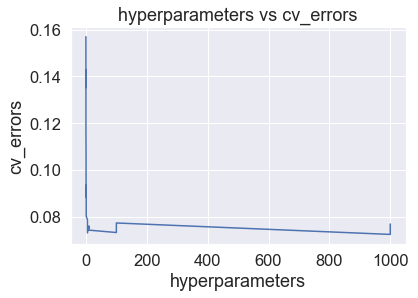

In [53]:

hy_params = [val[0]['C'] for val in grid_scores]

cv_errors = [1-val[1] for val in grid_scores]

#Calling the function for plot between C and cv_errors
param_cv_error(hy_params, cv_errors)

** Testing the model from best_estimator which can be return by the grid search cross validation.**

In [54]:
#Result showing the best classifier consisting of parameters
best_estimator

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [55]:
#Finding the predicted values for test labels using the test data
y_pred = best_estimator.predict(tfidf_test)

Accuracy on test data: 93.2
Precision on test data: 94.59
Recall on test data: 97.33
F1_score on test data: 95.94


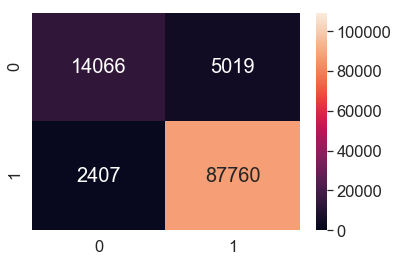

In [56]:
#Calling the function for test metrics
test_metrics(y_test, y_pred)

** Random Search Cross Validation:**

In [57]:
#Calling the function for random search cross validation
best_estimator = random_search(tfidf_tr, y_tr)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  3.6min
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:  7.0min finished


optimal hyperparameter: {'penalty': 'l2', 'C': 250}
Best accuracy: 92.71807183542813


** Testing the model from best_estimator which can be return by the random search cross validation.**

In [58]:
#Result showing the best classifier consisting of parameters
best_estimator

LogisticRegression(C=250, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [59]:
#Finding the predicted labels for test data
y_pred = best_estimator.predict(tfidf_test)

Accuracy on test data: 93.2
Precision on test data: 94.55
Recall on test data: 97.38
F1_score on test data: 95.94


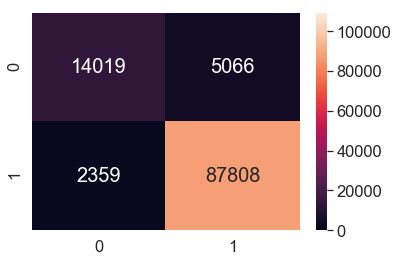

In [60]:
#Calling the function for test metrics
test_metrics(y_test, y_pred)

### 2. More Sparsity(Fewer elements of w* being non-zero) as C deceases or lambda increases using L1-regularization:

In [61]:
#To find number of non_zero elements with the C=10 and l1_reg
C=10
non_zero_ele(tfidf_tr, y_tr, C)

Number of non_zero elements in optimal vector for C=10 and l1_reg is 32358:


In [62]:
#To find number of non_zero elements with the C=10 and l1_reg
C=5
non_zero_ele(tfidf_tr, y_tr, C)

Number of non_zero elements in optimal vector for C=5 and l1_reg is 21163:


In [63]:
#To find number of non_zero elements with the C=10 and l1_reg
C=1
non_zero_ele(tfidf_tr, y_tr, C)

Number of non_zero elements in optimal vector for C=1 and l1_reg is 2656:


In [64]:
#To find number of non_zero elements with the C=10 and l1_reg
C=0.1
non_zero_ele(tfidf_tr, y_tr, C)

Number of non_zero elements in optimal vector for C=0.1 and l1_reg is 339:


In [65]:
#To find number of non_zero elements with the C=10 and l1_reg
C=0.01
non_zero_ele(tfidf_tr, y_tr, C)

Number of non_zero elements in optimal vector for C=0.01 and l1_reg is 20:


### 3. Pertubation Test (Multi collinearity test):

In [31]:
#Training the model before adding the epsilon to training data
clf = LogisticRegression(penalty='l2', C=1000)
clf.fit(tfidf_tr, y_tr)

#find function takes input sparse or dense matrix and it can return row indices at 0, column indices at 1
#and values of non-zero elements at 2
weights = find(clf.coef_[0])[2]


In [32]:
tfidf_t = tfidf_tr

#Generating the random noise with N(0, 0.001), length should be non_zero elements in bow_tr
epsilon = random.normal(0, 0.1, find(tfidf_t)[0].size)

#Storing row, column and non_elements
a, b, c = find(tfidf_t)

#adding epsilon to all non_zero elements
tfidf_t[a, b] = epsilon + tfidf_t[a, b]

In [33]:
#Training the model after adding the epsilon to training data
clf1 = LogisticRegression(penalty='l2', C=1000)
clf1.fit(tfidf_t, y_tr)

#find function takes input sparse or dense matrix and it can return row indices at 0, column indices at 1
#and values of non-zero elements at 2
weights1 = find(clf1.coef_[0])[2]


In [34]:
weight_diff = (abs(weights - weights1)/weights) * 100

In [36]:
print(weight_diff[np.where(weight_diff > 50)].size)

1322430


### 4. Top 10 important Features for positive and negative classes:

In [71]:
#Getting the feature names from the count_vec
features = tfidf_vect.get_feature_names()

#Combining coefficient values with the corresponding features
coefs_with_fea = sorted(zip(clf.coef_[0], features))

print("Top 10 positive important features:", [a[1] for a in coefs_with_fea[-10:]])
print("*"*100)
print("Top 10 negative important features:", [a[1] for a in coefs_with_fea[:10]])

Top 10 positive important features: ['awesom', 'amaz', 'wont disappoint', 'excel', 'love', 'perfect', 'best', 'high recommend', 'delici', 'great']
****************************************************************************************************
Top 10 negative important features: ['worst', 'two star', 'disappoint', 'terribl', 'aw', 'horribl', 'threw', 'disgust', 'return', 'bland']


# Avg_w2v: 
                    
          1. W2V can take the semantic meaning of the words.
          2. W2V can convert each word into an vector.
          3. Avg_W2V means for each review vector should be (W2V(word1) + W2V(word2)--------+ W2V(wordn)/(total no.of words).

In [43]:
#Forming the list_of_words for 50k reviews
sent_words = []
for sent in X:
    sent_words.append(sent.split())

In [44]:
#Splitting the into train and test data
X_tr_w2v, X_test_w2v, y_tr_w2v, y_test_w2v = train_test_split(sent_words, y, test_size=0.3, shuffle=False)

In [45]:
#Word to vectors for train data
w2v = gensim.models.Word2Vec(X_tr_w2v,min_count=5,size=50)

In [46]:
#storing w2v_words which can be return by w2v vocabilary
w2v_words = list(w2v.wv.vocab)
print("total words in w2v",len(w2v_words))
print(w2v_words[0:10])

total words in w2v 19107
['witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'recit', 'car', 'drive']


In [47]:
#Function for Avg_w2v
def avg_w2v(data, w2v, w2v_words):
    
    avg_vectors = []  #creating an empty list
    row = 0
    for sent in data:
        
        sent_vec = np.zeros(50)   #creating an vector which size should be 50 and all cells have zero's
        cnt_words = 0
        for word in sent:       #From each sentence taking word
            if word in w2v_words:
                vec = w2v.wv[word]   #Creating vector for word
                sent_vec += vec      #Combining all word vectors to create sentence vector
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
            avg_vectors.append(sent_vec)     
        row += 1 
        if cnt_words == 0:
            print(row)
    return avg_vectors

In [48]:

%%time 

#Avg w2v for train data
X_tr_avg_w2v = avg_w2v(X_tr_w2v, w2v, w2v_words)

192902
227729
Wall time: 4min 36s


In [51]:
#Droping the labels of corresponding test reviews whose words not match with train vocabilory
y_tr_w2v.drop(labels=[192901, 227728], inplace=True)   

In [53]:
#Avg w2v for test data
X_test_avg_w2v = avg_w2v(X_test_w2v, w2v, w2v_words)

3296
101568


In [54]:
#Storing y_test_w2v indices because corresponding vectors are empty
r1 = 254918 + 3296
r2 = 254918 + 101568

In [55]:
#Droping the labels of corresponding test reviews whose words not match with train vocabilory
y_test_w2v.drop(labels=[r1, r2], inplace=True)   

###  Hyperparameter tunning using grid seach and random search cross validation:

** Grid Search Cross Validation:**

In [56]:
#Calling the Grid search function
grid_scores, best_estimator = grid_search(X_tr_avg_w2v, y_tr_w2v)

Fitting 5 folds for each of 22 candidates, totalling 110 fits


[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  6.6min
[Parallel(n_jobs=3)]: Done 110 out of 110 | elapsed: 16.1min finished


optimal hyperparameter: {'C': 100, 'penalty': 'l2'}
Best Accuracy: 89.250576660547


In [57]:
grid_scores[:2]

[mean: 0.89243, std: 0.00638, params: {'C': 1000, 'penalty': 'l1'},
 mean: 0.89250, std: 0.00634, params: {'C': 1000, 'penalty': 'l2'}]

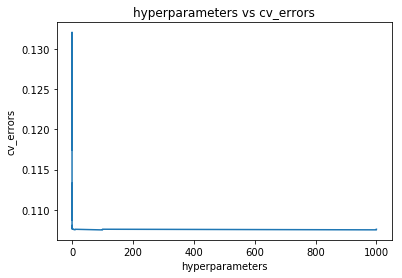

In [58]:

hy_params = [val[0]['C'] for val in grid_scores]

cv_errors = [1-val[1] for val in grid_scores]

#Calling the function for plot between C and cv_errors
param_cv_error(hy_params, cv_errors)

** Testing the model from best_estimator which can be return by the grid search cross validation.**

In [59]:
#Result showing the best classifier consisting of parameters
best_estimator

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [60]:
y_pred = best_estimator.predict(X_test_avg_w2v)

Accuracy on test data: 88.61
Precision on test data: 90.18
Recall on test data: 96.74
F1_score on test data: 93.34


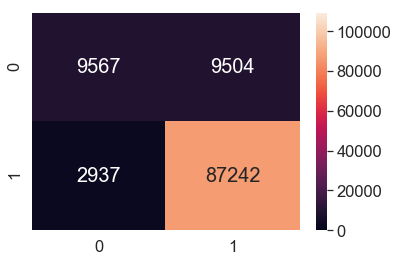

In [63]:
#Calling the function for test metrics
test_metrics(y_test_w2v, y_pred)

** Random Search Cross Validation:**

In [64]:
#Calling the function for random search cross validation
best_estimator = random_search(X_tr_avg_w2v, y_tr_w2v)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  4.7min
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:  9.9min finished


optimal hyperparameter: {'penalty': 'l2', 'C': 72}
Best accuracy: 89.250576660547


** Testing the model from best_estimator which can be return by the random search cross validation.**

In [65]:
#Result showing the best classifier consisting of parameters
best_estimator

LogisticRegression(C=72, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [66]:
y_pred = best_estimator.predict(X_test_avg_w2v)

Accuracy on test data: 88.61
Precision on test data: 90.18
Recall on test data: 96.74
F1_score on test data: 93.34


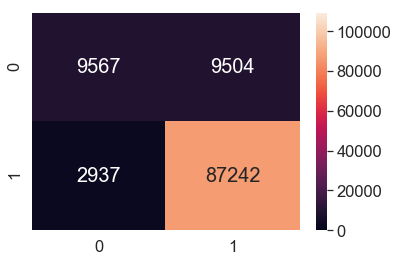

In [67]:
#Calling the function for test metrics
test_metrics(y_test_w2v, y_pred)

# TFIDF-w2v: 

In [68]:
#Previously done tfidf_w2v with the 50k points
#Getting the train data
tfidf_w2v_tr= openfromfile("tfidf_w2v_train_of_50k_pts")
y_tr_w2v = openfromfile("tfidf_y_tr_w2v_of_50k_pts")

In [69]:
#Getting the test data
tfidf_w2v_test = openfromfile("tfidf_w2v_test_of_50k_pts")
y_test_w2v = openfromfile("tfidf_y_test_w2v_of_50k_pts")

In [70]:
#Shape of the train and test data
print("Length of the train data:", len(tfidf_w2v_tr))
print("Length of the test data:", len(tfidf_w2v_test))

Length of the train data: 35000
Length of the test data: 10164


###  Hyperparameter tunning using grid seach and random search cross validation:

** Grid Search Cross Validation:**

In [71]:
#Calling the Grid search function
grid_scores, best_estimator = grid_search(tfidf_w2v_tr, y_tr_w2v)

Fitting 5 folds for each of 22 candidates, totalling 110 fits


[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:   17.8s
[Parallel(n_jobs=3)]: Done 110 out of 110 | elapsed:  1.0min finished


optimal hyperparameter: {'C': 10, 'penalty': 'l1'}
Best Accuracy: 90.09086233499058


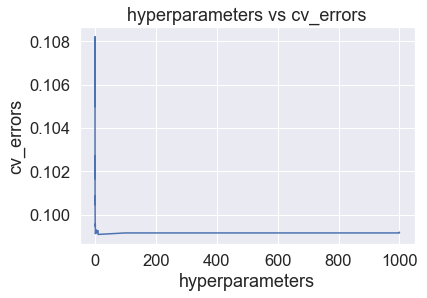

In [72]:

hy_params = [val[0]['C'] for val in grid_scores]

cv_errors = [1-val[1] for val in grid_scores]

#Calling the function for plot between C and cv_errors
param_cv_error(hy_params, cv_errors)

** Testing the model from best_estimator which can be return by the grid search cross validation.**

In [73]:
#Result showing the best classifier consisting of parameters
best_estimator

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [74]:
y_pred = best_estimator.predict(tfidf_w2v_test)

Accuracy on test data: 72.37
Precision on test data: 89.85
Recall on test data: 77.44
F1_score on test data: 83.19


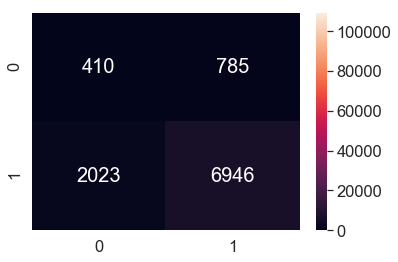

In [75]:
#Calling the function for test metrics
test_metrics(y_test_w2v, y_pred)

** Random Search Cross Validation:**

In [76]:
#Calling the function for random search cross validation
best_estimator = random_search(tfidf_w2v_tr, y_tr_w2v)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:   15.6s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:   29.6s finished


optimal hyperparameter: {'penalty': 'l1', 'C': 495}
Best accuracy: 90.0840048002743


In [77]:
#Result showing the best classifier consisting of parameters
best_estimator

LogisticRegression(C=495, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [78]:
y_pred = best_estimator.predict(tfidf_w2v_test)

Accuracy on test data: 72.37
Precision on test data: 89.85
Recall on test data: 77.44
F1_score on test data: 83.19


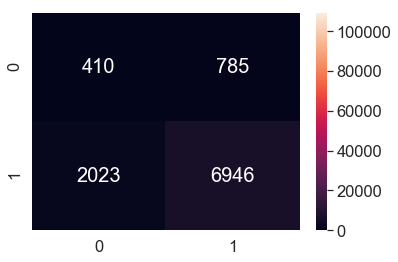

In [79]:
#Calling the function for test metrics
test_metrics(y_test_w2v, y_pred)

# Summary: 

** Performance Table: **

|Featurization  |sample size|CV           |Accuracy        |   F1-score  |C       | Penalty     | 
|---------------|-----------|-------------|----------------|-------------|--------|-------------|
|               |           |             |Test accuracy   |Test f1-score|        |             |
| BOW           |364k       |Grid Search  |91.85%          |95.15%       |10      |L2           |
|               |           |Ramdom Search|91.31%          |94.81%       |239     |L2           |              
|TF-IDF         |364k       |Grid Search  |93.20%          |95.94%       |1000    |L2           |
|               |           |Random Search|93.20%          |95.94%       |250     |L2           |
|Avg-W2V        |364k       |Grid Search  |88.61%          |93.34%       |100     |L2           |
|               |           |Random Search|88.61%          |93.34%       |72      |L2           |
|TF-IDF W2V     |50k        |Grid Search  |72.37%          |83.19%       |10      |L1           |
|               |           |Random Search|72.37%          |83.19%       |495     |L1           |

**Observation:** 

- TF_IDF is working well for this dataset with logistic regression.
- Using with L1 regularization, as C deceases then number of non-zero rows decreases.
- There is an collinearity between the attributes.
